# Assignment 2 - Calibration and DLT
**Author:** Johannes Holmgren

In [1]:
# Import external modules
# Uncomment below to have interactive 3D models
# %matplotlib widget
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from scipy.linalg import null_space, inv
import cv2
from skimage import transform

# Import internal modules/files
import plotter
import utils

In [2]:
# Load all matrix data
MAT_PATH = 'data/mat/'

compEx1data = loadmat(MAT_PATH + 'compEx1data.mat')

# Extract variables for computer exercise 1
x       = compEx1data['x'][0]
P       = compEx1data['P'][0]
X       = compEx1data['X']
imfiles = compEx1data['imfiles']

# Load all images
IMG_PATH = 'data/images/'

0.5


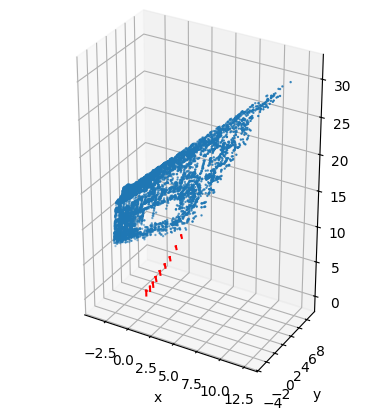

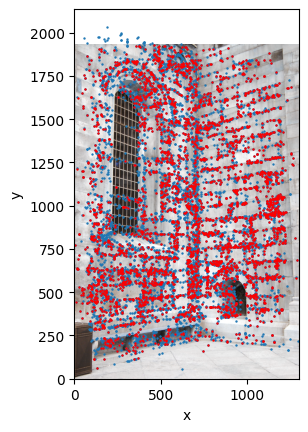

1


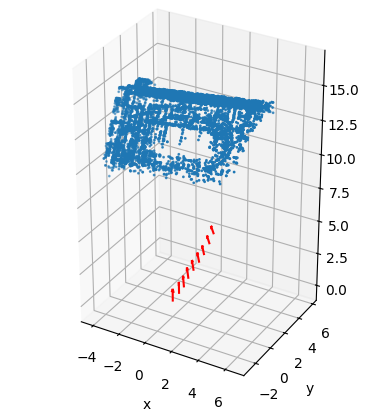

1


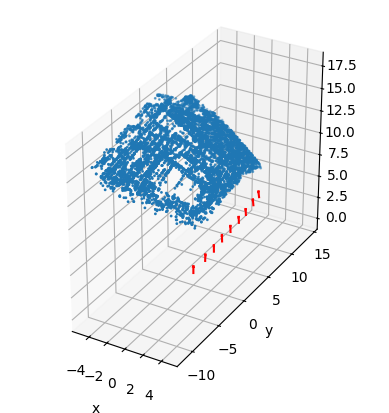

[[2.39395217e+03 0.00000000e+00 9.32382177e+02 0.00000000e+00]
 [0.00000000e+00 2.39811854e+03 6.28264995e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
[[2.39395217e+03 0.00000000e+00 9.32382177e+02 0.00000000e+00]
 [0.00000000e+00 7.99372847e+02 6.28264995e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]


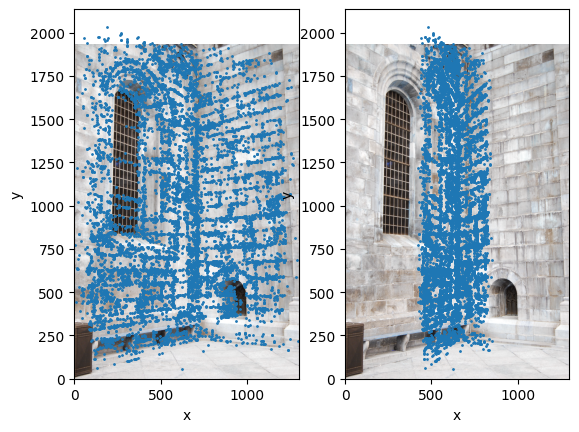

In [ ]:
# Computer Exercise 1
fig = plt.figure()
ax_3D = fig.add_subplot(111, projection='3d')
ax_3D.set_aspect('equal')

# Plot 3D points
plotter.plot_points_3D(ax_3D, X, s=0.5)

# Plot cameras
cameras = [utils.camera_center_and_axis(camera) for camera in P]
centers, axes = map(np.array, zip(*cameras))
plotter.plot_cams(ax_3D, centers, axes, 1)

plt.show()

### Answer to question: Yes the phyiscal properties look realistic

# Project into Camera 1
CAMERA_INDEX = 0
fig_2D, ax_2D = plt.subplots()
ax_2D.set_aspect('equal')

# Display image
image = cv2.imread(IMG_PATH + imfiles[CAMERA_INDEX][0][0])
ax_2D.imshow(cv2.flip(image, 0))
ax_2D.invert_yaxis()

X_norm = utils.pflat(X)
X_proj = np.matmul(P[CAMERA_INDEX], X_norm)
X_proj_norm = utils.pflat(X_proj)

plotter.plot_points_2D(ax_2D, X_proj_norm, s=0.5, rev=True)
plotter.plot_points_2D(ax_2D, x[CAMERA_INDEX], c='r', s=0.5, rev=True)

plt.show()

### Answer to the questions: Yes the points are very close to each other

T1 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [1/16, 1/16, 0, 1]
])
T2 = np.array([
    [1, 0, 0, 0],
    [0, 3, 0, 0],
    [0, 0, 1, 0],
    [1/9, 1/9, 0, 1]
])

# Transform 3D coordinates using T1 and T2
X_T1 = np.matmul(T1, X_norm)
X_T1_norm = utils.pflat(X_T1)
X_T2 = np.matmul(T2, X_norm)
X_T2_norm = utils.pflat(X_T2)

# Transform cameras by multiplying P*H_inv
P_T1 = np.array([np.matmul(p, inv(T1)) for p in P])
P_T2 = np.array([np.matmul(p, inv(T2)) for p in P])
P_T1_norm = utils.pflat(P_T1)
P_T2_norm = utils.pflat(P_T2)

# Plot T1 Cameras and Points
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.set_aspect('equal')

cameras = [utils.camera_center_and_axis(camera) for camera in P_T1]
centers, axes = map(np.array, zip(*cameras))

plotter.plot_cams(ax_3D, centers, axes, 1)
plotter.plot_points_3D(ax_3D, X_T1_norm)
plt.show()

# Plot T2 Cameras and Points
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.set_aspect('equal')

cameras = [utils.camera_center_and_axis(camera) for camera in P_T2]
centers, axes = map(np.array, zip(*cameras))

plotter.plot_cams(ax_3D, centers, axes, 1)
plotter.plot_points_3D(ax_3D, X_T2_norm)
plt.show()

### Answer to question: Yes, the first transform (T1) looks very reasonable

# Project new 3D points for T1 and T2 onto the transformed camera P1
def project_and_plot(ax, P, Xs, image):
    ''' Project Xs onto P and plot in same figure as image
    
    TBD
    '''
    X_norm = utils.pflat(Xs)
    X_proj = np.matmul(P, X_norm)
    X_proj_norm = utils.pflat(X_proj)
    ax.imshow(cv2.flip(image, 0))
    ax.invert_yaxis()
    plotter.plot_points_2D(ax, X_proj_norm, rev=True)


fig_2D, axs_2D = plt.subplots(1, 2)
axs_2D[0].set_aspect('equal')
axs_2D[1].set_aspect('equal')

# Project points onto each transformed camera
P_T1_1 = P_T1[CAMERA_INDEX]
P_T2_1 = P_T2[CAMERA_INDEX]

X_proj_1 = np.matmul(P_T1_1, X)
X_proj_1_norm = utils.pflat(X_proj_1)
X_proj_2 = np.matmul(P_T2_1, X)
X_proj_2_norm = utils.pflat(X_proj_2)

project_and_plot(axs_2D[0], P_T1_1, X, image)
project_and_plot(axs_2D[1], P_T2_1, X, image)

### Answer to question: T1 seems to do a proper projection onto the image, while the other gives a compacted version
